In [1]:
import numpy as np
import pandas as pd
import os
import requests
import io
from datetime import datetime, timedelta
import multiprocessing
import arviz as az
import logging
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import xgboost as xgb
from scipy.stats import poisson

In [2]:
# get data
API_KEY = os.getenv("API_KEY")
url = 'https://data-service.beatthebookie.blog/data'
headers = {"x-api-key": API_KEY}

# Function to fetch data for a specific division and season
def fetch_data(division, season):
    params = {
        'division': division,
        'season': season
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return pd.read_json(io.StringIO(response.content.decode('utf-8')))
    else:
        print(f"Error fetching {division} {season}: {response.status_code}")
        print(response.content.decode('utf-8'))
        return pd.DataFrame()

# Fetch data for all combinations
seasons = ['2024_2025', '2023_2024', '2022_2023', '2021_2022']
divisions = ['Premier League', 'Championship']
dataframes = []

for division in divisions:
    for season in seasons:
        df = fetch_data(division, season)
        if not df.empty:
            dataframes.append(df)

# Combine all dataframes
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    
    # Convert match_date to datetime
    df['match_date'] = pd.to_datetime(df['match_date'])

df

,division_id,division,season_id,season,match_date,match_teams,home_team_id,home_team,away_team_id,away_team,...,away_xgoals,home_deep,away_deep,home_ppda,away_ppda,bet365_home_odds,bet365_draw_odds,bet365_away_odds,bet365_u25_odds,bet365_o25_odds
0,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-16,Man United - Fulham,f2b82cdbdadf9d3ec47c3a6be66dcfad,Man United,8cd5e94668b139c1f42a89a1e130f3cf,Fulham,...,0.418711,7.0,3.0,7.379310,10.833333,1.60,4.20,5.25,2.50,1.53
1,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Everton - Brighton,6414a61d98ab23b6d757e888ab17a66a,Everton,0d84883ca72c88cb53c8a38262efdcbc,Brighton,...,1.790830,4.0,5.0,18.333333,7.916667,2.63,3.30,2.63,2.00,1.80
2,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Ipswich - Liverpool,e4f63bf6d6d2cd121e6c8e59bef68209,Ipswich,afce84ff226407a47c9782a742ba02f7,Liverpool,...,3.929060,2.0,13.0,18.777778,8.739130,8.50,5.50,1.33,3.00,1.40
3,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Nott'm Forest - Bournemouth,9a8e1e9fad8766fc3d69a0c26d98b928,Nott'm Forest,b436d55f36cfbe8a085c8b75fb7fe98a,Bournemouth,...,1.909150,10.0,4.0,8.653846,9.954545,2.45,3.50,2.80,2.10,1.73
4,98b8784f6685b7289f583e0ce4b4f6f2,Premier League,3ac445d3cc1d404987efdfcfa42f3bcd,20242025,2024-08-17,Newcastle - Southampton,78e9266876e7649e0a12e3840f5be006,Newcastle,5a884401673693b0bdf379fefb7ec2b2,Southampton,...,1.954830,4.0,13.0,16.250000,3.789474,1.36,5.25,8.00,3.00,1.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,06b84148ed1c6a06340478bef065f5bc,20212022,2022-05-07,Huddersfield - Bristol City,5668c64f7d3e02ee708188dbe0fdaa4e,Huddersfield,b69f5235edbfe00c680f756eba63f7be,Bristol City,...,0.800000,NaN,NaN,NaN,NaN,1.90,3.60,3.90,2.10,1.72
3517,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,06b84148ed1c6a06340478bef065f5bc,20212022,2022-05-07,Luton - Reading,20ee5d666fa2428304848c9ebf2cf8b2,Luton,26fccddf2f94b1685b184267996e10f8,Reading,...,0.600000,NaN,NaN,NaN,NaN,1.50,4.20,7.00,2.20,1.66
3518,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,06b84148ed1c6a06340478bef065f5bc,20212022,2022-05-07,Sheffield United - Fulham,851eb9d41bc5f8ef6237ecb99c9720ce,Sheffield United,8cd5e94668b139c1f42a89a1e130f3cf,Fulham,...,0.700000,NaN,NaN,NaN,NaN,2.00,3.50,3.75,2.00,1.80
3519,c4781225ef2d5018f7a9df4b6cb1c1fe,Championship,06b84148ed1c6a06340478bef065f5bc,20212022,2022-05-07,Bournemouth - Millwall,b436d55f36cfbe8a085c8b75fb7fe98a,Bournemouth,ea11a8d754f9bbf49dc01d6d3ae875d9,Millwall,...,0.500000,NaN,NaN,NaN,NaN,1.95,3.60,3.80,2.10,1.72


In [3]:
# Separates out the home vs away and allows every team to have an individual row of data. Allows us to feature engineer home effect easier.
home_df = df[["division", "season", "match_date",
             "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_shots_on_target", "home_corners", "home_xgoals", "home_deep", "home_ppda", "home_red",
             "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_shots_on_target", "away_corners", "away_xgoals", "away_deep", "away_ppda", "away_red",
              "bet365_home_odds", "bet365_draw_odds", "bet365_away_odds"]].copy()
home_df["home?"] = 1
home_df = home_df.rename(columns={"home_team":"team", "home_avg_market_value":"avg_market_value", "home_goals":"goals",
             "home_shots":"shots", "home_shots_on_target":"shots_on_target", "home_corners":"corners", "home_xgoals":"xG", "home_deep":"deep", "home_ppda":"ppda", "home_red": "red",
             "away_team":"opponent_team", "away_avg_market_value":"opponent_avg_market_value", "away_goals":"opponent_goals", 
             "away_shots": "opponent_shots", "away_shots_on_target":"opponent_shots_on_target", "away_corners":"opponent_corners", "away_xgoals": "opponent_xG", 
             "away_deep":"opponent_deep", "away_ppda":"opponent_ppda", "away_red": "opponent_red"})

away_df = df[["division", "season", "match_date",
                "away_team", "away_avg_market_value", "away_goals", "away_shots", "away_shots_on_target", "away_corners", "away_xgoals", "away_deep", "away_ppda", "away_red",
                "home_team", "home_avg_market_value", "home_goals", "home_shots", "home_shots_on_target", "home_corners", "home_xgoals", "home_deep", "home_ppda", "home_red",
                 "bet365_home_odds", "bet365_draw_odds", "bet365_away_odds"]].copy()
away_df["home?"] = 0
away_df = away_df.rename(columns={"away_team":"team", "away_avg_market_value":"avg_market_value", "away_goals":"goals",
             "away_shots":"shots", "away_shots_on_target":"shots_on_target", "away_corners":"corners", "away_xgoals":"xG", "away_deep":"deep", "away_ppda":"ppda", "away_red": "red",
             "home_team":"opponent_team", "home_avg_market_value":"opponent_avg_market_value", "home_goals":"opponent_goals", 
             "home_shots": "opponent_shots", "home_shots_on_target":"opponent_shots_on_target", "home_corners":"opponent_corners", "home_xgoals": "opponent_xG", 
             "home_deep":"opponent_deep", "home_ppda":"opponent_ppda", "home_red": "opponent_red"})

df = pd.concat([away_df, home_df])
df["prem?"] = df["division"].apply(lambda x: 1 if x == "Premier League" else 0)
df.sort_values(["match_date", "division"], inplace=True)

df

,division,season,match_date,team,avg_market_value,goals,shots,shots_on_target,corners,xG,...,opponent_corners,opponent_xG,opponent_deep,opponent_ppda,opponent_red,bet365_home_odds,bet365_draw_odds,bet365_away_odds,home?,prem?
2969,Championship,20212022,2021-08-06,West Brom,4487500,2,15.0,5,8,2.1,...,4,0.7,NaN,NaN,0,2.30,3.25,3.2,0,0
2969,Championship,20212022,2021-08-06,Bournemouth,5313636,2,7.0,4,4,0.7,...,8,2.1,NaN,NaN,0,2.30,3.25,3.2,1,0
2970,Championship,20212022,2021-08-07,Reading,2079412,2,11.0,5,9,1.0,...,6,2.0,NaN,NaN,0,2.05,3.25,3.8,0,0
2971,Championship,20212022,2021-08-07,Peterboro,391860,0,4.0,1,2,0.2,...,7,2.2,NaN,NaN,0,2.10,3.40,3.4,0,0
2972,Championship,20212022,2021-08-07,Birmingham,1458621,1,9.0,2,2,1.1,...,8,0.9,NaN,NaN,0,1.75,3.50,5.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,Championship,20242025,2025-03-12,FC Portsmouth,515357,1,16.0,3,7,1.4,...,0,0.3,NaN,NaN,1,1.67,3.70,5.0,1,0
1861,Championship,20242025,2025-03-12,Leeds,8399000,2,18.0,2,4,0.8,...,3,0.2,NaN,NaN,0,1.29,5.25,10.0,1,0
1862,Championship,20242025,2025-03-12,Watford,1941071,1,9.0,2,1,0.6,...,6,0.7,NaN,NaN,0,2.30,3.25,3.1,1,0
1863,Championship,20242025,2025-03-12,Stoke,1480357,1,8.0,3,3,1.4,...,4,0.5,NaN,NaN,0,2.60,3.30,2.7,1,0


In [54]:
def apply_weighted_avg(col, match_date, match_red, division=None, decay_rate=0.005, time_window=365):
    # Create a mask for non-NaN values
    valid_mask = ~pd.isna(col)
    
    # If all values are NaN, return NaN
    if not valid_mask.any():
        return np.nan
    
    # Filter out NaN values
    valid_col = col[valid_mask].copy()  # Create a copy to avoid modifying original
    valid_dates = match_date[valid_mask]
    valid_red = match_red[valid_mask]
    
    # Get division for valid entries
    valid_division = None
    if division is not None:
        valid_division = division[valid_mask]
    
    # Apply Championship adjustment if division is provided
    if division is not None:
        # Check if this is for an attacking or defensive metric
        is_attacking = 'opponent' not in str(col.name).lower() if hasattr(col, 'name') else False
        is_ppda = 'ppda' in str(col.name).lower() if hasattr(col, 'name') else False
        
        # Create a new numpy array from the Series values
        values_array = valid_col.to_numpy()
        
        # Apply the appropriate adjustment based on metric type
        for i, div in enumerate(valid_division):
            if div == 'Championship':
                if is_attacking:
                    if is_ppda:
                        values_array[i] *= 1.4  # For PPDA, higher is worse for attack
                    else:
                        values_array[i] *= 0.7  # Reduce attacking stats by 40%
                else:
                    if is_ppda:
                        values_array[i] *= 0.7  # For PPDA, lower is better for defense
                    else:
                        values_array[i] *= 1.4  # Increase defensive stats by 40%
        
        # Replace the Series values with the modified array
        valid_col = pd.Series(values_array, index=valid_col.index)
    
    # Get most recent date
    recent_date = max(valid_dates)
    
    # Create a time window mask (only include matches within time_window days)
    time_window_mask = (recent_date - valid_dates).dt.days <= time_window
    
    # If no matches in the time window, return NaN
    if not time_window_mask.any():
        return np.nan
    
    # Apply time window filter
    valid_col = valid_col[time_window_mask]
    valid_dates = valid_dates[time_window_mask]
    valid_red = valid_red[time_window_mask]
    
    if division is not None:
        valid_division = valid_division[time_window_mask]
    
    # Calculate weights for matches within the time window
    match_weight = np.exp(-(recent_date - valid_dates).dt.days * decay_rate)
    
    # Reduce weight for matches with red cards (now using 0.3 instead of 0.5)
    match_weight = np.where(valid_red == 1, match_weight * 0.3, match_weight)
    
    # Reduce weight for Championship matches (0.5 weight compared to Premier League)
    if division is not None:
        match_weight = np.where(valid_division == 'Championship', match_weight * 0.5, match_weight)

    # Calculate weighted average
    weighted_avg = sum(match_weight * valid_col) / sum(match_weight) 

    return weighted_avg

In [55]:
# Assuming df is already sorted by match_date
df = df.sort_values(['team', 'match_date'])

def calc_team_metrics_up_to_date(team, current_date, decay_rate=0.0065, time_window=365):
    # Get all matches for the team up to but not including the current date
    team_matches = df[(df['team'] == team) & (df['match_date'] < current_date)]
    
    # If no prior matches, return NaN for all metrics
    if len(team_matches) == 0:
        return pd.Series({
            'rolling_goals_for': np.nan,
            'rolling_goals_against': np.nan,
            'rolling_xg_for': np.nan,
            'rolling_xg_against': np.nan,
            'rolling_shots_for': np.nan,
            'rolling_shots_against': np.nan,
            'rolling_shots_on_target_for': np.nan,
            'rolling_shots_on_target_against': np.nan,
            'rolling_corners_for': np.nan,
            'rolling_corners_against': np.nan,
            'rolling_deep_for': np.nan,
            'rolling_deep_against': np.nan,
            'rolling_ppda_for': np.nan,
            'rolling_ppda_against': np.nan
        })
    
    # Calculate metrics using the original weighted average function
    metrics = {
        'rolling_goals_for': apply_weighted_avg(
            team_matches['goals'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_goals_against': apply_weighted_avg(
            team_matches['opponent_goals'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_xg_for': apply_weighted_avg(
            team_matches['xG'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_xg_against': apply_weighted_avg(
            team_matches['opponent_xG'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_shots_for': apply_weighted_avg(
            team_matches['shots'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_shots_against': apply_weighted_avg(
            team_matches['opponent_shots'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_shots_on_target_for': apply_weighted_avg(
            team_matches['shots_on_target'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_shots_on_target_against': apply_weighted_avg(
            team_matches['opponent_shots_on_target'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_corners_for': apply_weighted_avg(
            team_matches['corners'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_corners_against': apply_weighted_avg(
            team_matches['opponent_corners'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_deep_for': apply_weighted_avg(
            team_matches['deep'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_deep_against': apply_weighted_avg(
            team_matches['opponent_deep'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_ppda_for': apply_weighted_avg(
            team_matches['ppda'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
        'rolling_ppda_against': apply_weighted_avg(
            team_matches['opponent_ppda'], team_matches['match_date'], team_matches['red'], team_matches['division'],
            decay_rate, time_window
        ),
    }
    
    return pd.Series(metrics)


# Apply the function to each row for team stats
team_results = []
opponent_results = []

for idx, row in df.iterrows():
    # Calculate team metrics
    team_metrics = calc_team_metrics_up_to_date(row['team'], row['match_date'])
    
    # Calculate opponent metrics
    opponent_metrics = calc_team_metrics_up_to_date(row['opponent_team'], row['match_date'])
    
    # Rename opponent metrics with a clearer naming convention
    opponent_metrics = pd.Series({
        'opponent_rolling_goals_for': opponent_metrics['rolling_goals_for'],
        'opponent_rolling_goals_against': opponent_metrics['rolling_goals_against'],
        'opponent_rolling_xg_for': opponent_metrics['rolling_xg_for'],
        'opponent_rolling_xg_against': opponent_metrics['rolling_xg_against'],
        'opponent_rolling_shots_for': opponent_metrics['rolling_shots_for'],
        'opponent_rolling_shots_against': opponent_metrics['rolling_shots_against'],
        'opponent_rolling_shots_on_target_for': opponent_metrics['rolling_shots_on_target_for'],
        'opponent_rolling_shots_on_target_against': opponent_metrics['rolling_shots_on_target_against'],
        'opponent_rolling_corners_for': opponent_metrics['rolling_corners_for'],
        'opponent_rolling_corners_against': opponent_metrics['rolling_corners_against'],
        'opponent_rolling_deep_for': opponent_metrics['rolling_deep_for'],
        'opponent_rolling_deep_against': opponent_metrics['rolling_deep_against'],
        'opponent_rolling_ppda_for': opponent_metrics['rolling_ppda_for'],
        'opponent_rolling_ppda_against': opponent_metrics['rolling_ppda_against']
    })
    
    team_results.append(team_metrics)
    opponent_results.append(opponent_metrics)

# Create DataFrames from the results
team_metrics_df = pd.DataFrame(team_results, index=df.index)
opponent_metrics_df = pd.DataFrame(opponent_results, index=df.index)

# Check for duplicated columns before concatenation
print("Team metrics columns:", team_metrics_df.columns.tolist())
print("Opponent metrics columns:", opponent_metrics_df.columns.tolist())

# Combine everything into the final DataFrame
final_df = pd.concat([df, team_metrics_df, opponent_metrics_df], axis=1)

Team metrics columns: ['rolling_goals_for', 'rolling_goals_against', 'rolling_xg_for', 'rolling_xg_against', 'rolling_shots_for', 'rolling_shots_against', 'rolling_shots_on_target_for', 'rolling_shots_on_target_against', 'rolling_corners_for', 'rolling_corners_against', 'rolling_deep_for', 'rolling_deep_against', 'rolling_ppda_for', 'rolling_ppda_against']
Opponent metrics columns: ['opponent_rolling_goals_for', 'opponent_rolling_goals_against', 'opponent_rolling_xg_for', 'opponent_rolling_xg_against', 'opponent_rolling_shots_for', 'opponent_rolling_shots_against', 'opponent_rolling_shots_on_target_for', 'opponent_rolling_shots_on_target_against', 'opponent_rolling_corners_for', 'opponent_rolling_corners_against', 'opponent_rolling_deep_for', 'opponent_rolling_deep_against', 'opponent_rolling_ppda_for', 'opponent_rolling_ppda_against']


In [56]:
dupe_cols = final_df.columns[final_df.columns.duplicated()]
print(f"Found {len(dupe_cols)} duplicated columns: {dupe_cols.tolist()}")

# Keep only the first occurrence of each column name
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

Found 0 duplicated columns: []


In [57]:
final_df

,division,season,match_date,team,avg_market_value,goals,shots,shots_on_target,corners,xG,...,opponent_rolling_shots_for,opponent_rolling_shots_against,opponent_rolling_shots_on_target_for,opponent_rolling_shots_on_target_against,opponent_rolling_corners_for,opponent_rolling_corners_against,opponent_rolling_deep_for,opponent_rolling_deep_against,opponent_rolling_ppda_for,opponent_rolling_ppda_against
1041,Premier League,20212022,2021-08-13,Arsenal,19750000,0,22.0,4,5,1.020000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1059,Premier League,20212022,2021-08-22,Arsenal,19888889,0,6.0,3,9,0.630000,...,13.000000,4.000000,6.000000,1.000000,5.000000,2.000000,14.000000,3.000000,6.600000,71.000000
1062,Premier League,20212022,2021-08-28,Arsenal,19888889,0,1.0,0,0,0.120000,...,16.980502,6.883015,4.000000,1.470754,8.451256,1.980502,12.077990,2.451256,6.894428,22.535315
1074,Premier League,20212022,2021-09-11,Arsenal,21096154,1,30.0,7,8,2.690000,...,9.669655,14.514592,2.349299,4.924538,4.425451,8.637263,1.652080,10.513213,21.178179,9.281317
1087,Premier League,20212022,2021-09-18,Arsenal,21096154,1,13.0,3,3,1.100000,...,11.460400,16.612197,3.835404,6.167269,5.496935,5.670064,3.025869,7.744998,13.815700,8.874163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
230,Premier League,20242025,2025-02-01,Wolves,10972727,2,8.0,5,5,2.001460,...,12.732923,12.417299,4.280599,4.395769,6.174513,4.357023,7.538991,5.797531,14.192534,11.115507
249,Premier League,20242025,2025-02-16,Wolves,10972727,1,16.0,4,3,1.053290,...,19.349882,9.652101,7.305312,3.541137,7.043623,3.919113,13.087073,4.566418,8.795691,19.442770
254,Premier League,20242025,2025-02-22,Wolves,10972727,1,13.0,5,7,2.101240,...,15.764507,14.000136,5.962439,4.937998,5.847354,5.388220,7.375804,9.569541,8.806390,9.608872
264,Premier League,20242025,2025-02-25,Wolves,10972727,1,18.0,5,7,0.928973,...,14.376291,10.418402,4.627416,4.043858,5.179545,4.254430,6.306246,5.556135,14.433246,14.779412


In [94]:
#final_df = final_df[final_df["match_date"] > '2023-08-01']

final_df = final_df[final_df["division"] == "Premier League"]
final_df["xg_interaction"] = final_df["rolling_xg_for"] * final_df["opponent_rolling_xg_against"]

X = final_df[["division", "home?", "avg_market_value", "opponent_avg_market_value", #"xg_interaction",
             "rolling_goals_for", "rolling_xg_for", "rolling_shots_for", "rolling_shots_on_target_for", "rolling_corners_for", "rolling_deep_for", "rolling_ppda_for",
             "opponent_rolling_goals_against", "opponent_rolling_xg_against", "opponent_rolling_shots_against", "opponent_rolling_shots_on_target_against", "opponent_rolling_corners_against", "opponent_rolling_deep_against", "opponent_rolling_ppda_against",]]

# Convert categorical columns to category type
cat_cols = ["division"] #"team", "opponent_team"
for col in cat_cols:
    X[col] = X[col].astype('category')


y = final_df["goals"] 

feb_2025_cutoff = pd.to_datetime('2025-01-15')
X_train = X[final_df['match_date'] < feb_2025_cutoff]
y_train = y[final_df['match_date'] < feb_2025_cutoff]
X_test = X[final_df['match_date'] >= feb_2025_cutoff]
y_test = y[final_df['match_date'] >= feb_2025_cutoff]

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Train an XGBoost model
model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.7,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0,
    alpha=1,
    random_state=26,
    enable_categorical=True  # Enable categorical feature support
)

model.fit(X_train, y_train)

# Make predictions
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
print(f"RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Train MAE: {train_mae:.4f}")

X_test_has_nan = X_test.isna().any(axis=1)
y_test_has_nan = y_test.isna()

print(f"X_test rows with NaN: {X_test_has_nan.sum()}")
print(f"y_test rows with NaN: {y_test_has_nan.sum()}")

Training set size: 2686 samples
Test set size: 156 samples
RMSE: 1.2358
Test MAE: 0.9466
Train MAE: 0.8802
X_test rows with NaN: 0
y_test rows with NaN: 0


C:\Users\Owner\AppData\Local\Temp\ipykernel_648\3300790231.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = X[col].astype('category')


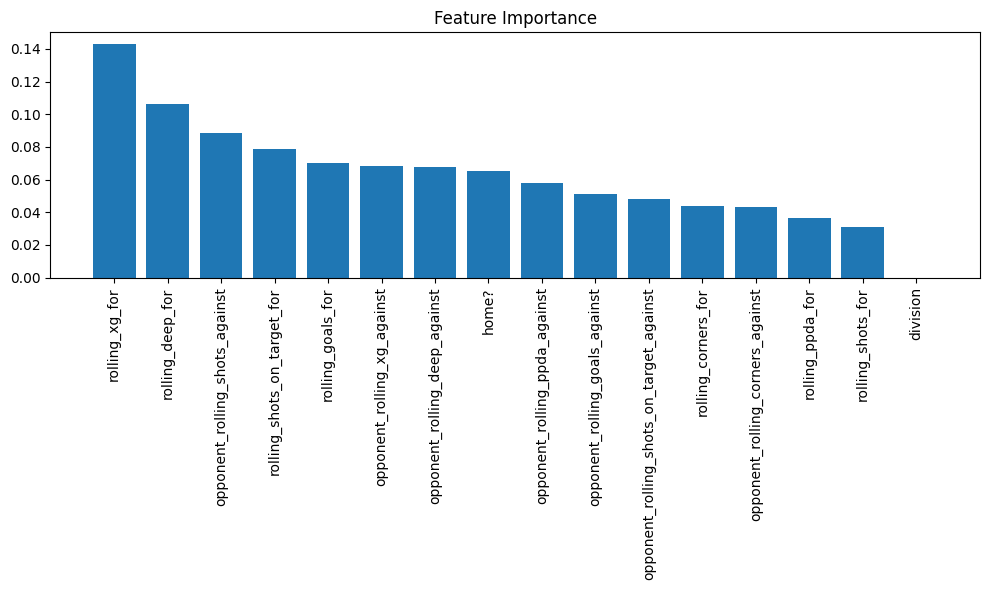

Feature importance ranking:
1. rolling_xg_for: 0.1431
2. rolling_deep_for: 0.1062
3. opponent_rolling_shots_against: 0.0887
4. rolling_shots_on_target_for: 0.0786
5. rolling_goals_for: 0.0702
6. opponent_rolling_xg_against: 0.0684
7. opponent_rolling_deep_against: 0.0678
8. home?: 0.0651
9. opponent_rolling_ppda_against: 0.0581
10. opponent_rolling_goals_against: 0.0514
11. opponent_rolling_shots_on_target_against: 0.0481
12. rolling_corners_for: 0.0437
13. opponent_rolling_corners_against: 0.0430
14. rolling_ppda_for: 0.0367
15. rolling_shots_for: 0.0308
16. division: 0.0000


In [88]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming best_model is your trained XGBoost model from GridSearchCV
# Get feature importance
importance = model.feature_importances_

# Get feature names (assuming your X_train is a pandas DataFrame)
# If not, you'll need to create a list of feature names
feature_names = X_train.columns

# Sort importance in descending order
indices = np.argsort(importance)[::-1]

# Plot
plt.figure(figsize=(10, 6))
plt.title('Feature Importance')
plt.bar(range(len(importance)), importance[indices])
plt.xticks(range(len(importance)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

# Print feature importance in descending order
print("Feature importance ranking:")
for i, idx in enumerate(indices):
    print(f"{i+1}. {feature_names[idx]}: {importance[idx]:.4f}")

In [60]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import xgboost as xgb

# Define parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.03, 0.05, 0.1, 0.2],
    'max_depth': [2, 3, 4, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1],
    # Add regularization parameters
    'alpha': [0, 0.5, 1],  # L1 regularization
    'lambda': [1, 1.5, 2]  # L2 regularization
}

# Create base model
xgb_model = xgb.XGBRegressor(
    random_state=26,
    enable_categorical=True
)

# Create a TimeSeriesSplit object
# Assuming your data is chronologically ordered
tscv = TimeSeriesSplit(
    n_splits=5,  # 5 temporal folds
    test_size=int(len(X_train) * 0.2)  # Each validation set is ~20% of data
)

# Set up GridSearchCV with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,  # Use time series cross-validation
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=4,
    return_train_score=True  # Useful to check for overfitting
)

# Make sure data is sorted chronologically before fitting
# Assuming df has a 'match_date' column
# df = df.sort_values('match_date')
# X_train, y_train should be derived from the sorted dataframe

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best CV score:", -grid_search.best_score_)  # Convert back from negative MAE

# Create model with best parameters
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 15552 candidates, totalling 77760 fits


KeyboardInterrupt: 

In [ ]:
# Reset index before splitting to avoid duplicate indices
X_with_reset_index = X.reset_index(drop=True)
y_with_reset_index = y.reset_index(drop=True)
final_df_reset = final_df.reset_index(drop=True)

# Now split using the reset data
X_train = X_with_reset_index[final_df_reset['match_date'] < feb_2025_cutoff]
y_train = y_with_reset_index[final_df_reset['match_date'] < feb_2025_cutoff]
X_test = X_with_reset_index[final_df_reset['match_date'] >= feb_2025_cutoff]
y_test = y_with_reset_index[final_df_reset['match_date'] >= feb_2025_cutoff]

# Train and predict as before
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Now creating the results DataFrame is simple
test_results = pd.DataFrame({
    'actual_goals': y_test,
    'predicted_goals': y_pred,
    'error': y_test - y_pred,
    'abs_error': abs(y_test - y_pred)
})

# Add match information - this will align correctly since indices are reset
test_results['match_date'] = final_df_reset.loc[y_test.index, 'match_date']
test_results['team'] = final_df_reset.loc[y_test.index, 'team']
test_results['opponent_team'] = final_df_reset.loc[y_test.index, 'opponent_team']
test_results['home'] = final_df_reset.loc[y_test.index, 'home?']
test_results['division'] = final_df_reset.loc[y_test.index, 'division']

# Sort by date
test_results = test_results.sort_values('match_date')

test_results[test_results["division"] == 'Premier League']

,actual_goals,predicted_goals,error,abs_error,match_date,team,opponent_team,home,division
134,2,2.181773,-0.181773,0.181773,2025-01-15,Arsenal,Tottenham,1,Premier League
1025,2,1.856161,0.143839,0.143839,2025-01-15,Crystal Palace,Leicester,0,Premier League
2086,3,2.294161,0.705839,0.705839,2025-01-15,Newcastle,Wolves,1,Premier League
1479,0,1.270122,-1.270122,1.270122,2025-01-15,Leicester,Crystal Palace,1,Premier League
276,1,1.624850,-0.624850,0.624850,2025-01-15,Aston Villa,Everton,0,Premier League
...,...,...,...,...,...,...,...,...,...
388,2,1.907307,0.092693,0.092693,2025-03-09,Bournemouth,Tottenham,0,Premier League
141,1,2.160312,-1.160312,1.160312,2025-03-09,Arsenal,Man United,0,Premier League
1486,0,0.920710,-0.920710,0.920710,2025-03-09,Leicester,Chelsea,0,Premier League
2699,0,1.289249,-1.289249,1.289249,2025-03-10,West Ham,Newcastle,1,Premier League


In [92]:
def predict_match(trained_model, X_test, home_team, away_team, division="Premier League", match_date=None, debug=True):
    # Set match_date if not provided
    if match_date is None:
        match_date = datetime.now()
    elif isinstance(match_date, str):
        match_date = pd.to_datetime(match_date)
    
    # Calculate metrics using calc_team_metrics_up_to_date function for both teams
    home_metrics = calc_team_metrics_up_to_date(home_team, match_date)
    away_metrics = calc_team_metrics_up_to_date(away_team, match_date)
    
    # Get market values (assuming these are available in your dataset)
    home_market_value = df[df['team'] == home_team].iloc[-1]['avg_market_value'] if len(df[df['team'] == home_team]) > 0 else np.nan
    away_market_value = df[df['team'] == away_team].iloc[-1]['avg_market_value'] if len(df[df['team'] == away_team]) > 0 else np.nan
    
    # Calculate the interaction term for both home and away
    home_xg_interaction = home_metrics['rolling_xg_for'] * away_metrics['rolling_xg_against']
    away_xg_interaction = away_metrics['rolling_xg_for'] * home_metrics['rolling_xg_against']
    
    # Create prediction features for home team
    home_features = pd.DataFrame({
        'division': [division],
        'home?': [1],
        'avg_market_value': [home_market_value],
        'opponent_avg_market_value': [away_market_value],
        #'xg_interaction': [home_xg_interaction],
        'rolling_goals_for': [home_metrics['rolling_goals_for']],
        'rolling_xg_for': [home_metrics['rolling_xg_for']],
        'rolling_shots_for': [home_metrics['rolling_shots_for']],
        'rolling_shots_on_target_for': [home_metrics['rolling_shots_on_target_for']],
        'rolling_corners_for': [home_metrics['rolling_corners_for']],
        'rolling_deep_for': [home_metrics['rolling_deep_for']],
        'rolling_ppda_for': [home_metrics['rolling_ppda_for']],
        'opponent_rolling_goals_against': [away_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [away_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [away_metrics['rolling_shots_against']],
        'opponent_rolling_shots_on_target_against': [away_metrics['rolling_shots_on_target_against']],
        'opponent_rolling_corners_against': [away_metrics['rolling_corners_against']],
        'opponent_rolling_deep_against': [away_metrics['rolling_deep_against']],
        'opponent_rolling_ppda_against': [away_metrics['rolling_ppda_against']]
    })
    
    # Create prediction features for away team
    away_features = pd.DataFrame({
        'division': [division],
        'home?': [0],
        'avg_market_value': [away_market_value],
        'opponent_avg_market_value': [home_market_value],
        #'xg_interaction': [away_xg_interaction] ,
        'rolling_goals_for': [away_metrics['rolling_goals_for']],
        'rolling_xg_for': [away_metrics['rolling_xg_for']],
        'rolling_shots_for': [away_metrics['rolling_shots_for']],
        'rolling_shots_on_target_for': [away_metrics['rolling_shots_on_target_for']],
        'rolling_corners_for': [away_metrics['rolling_corners_for']],
        'rolling_deep_for': [away_metrics['rolling_deep_for']],
        'rolling_ppda_for': [away_metrics['rolling_ppda_for']],
        'opponent_rolling_goals_against': [home_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [home_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [home_metrics['rolling_shots_against']],
        'opponent_rolling_shots_on_target_against': [home_metrics['rolling_shots_on_target_against']],
        'opponent_rolling_corners_against': [home_metrics['rolling_corners_against']],
        'opponent_rolling_deep_against': [home_metrics['rolling_deep_against']],
        'opponent_rolling_ppda_against': [home_metrics['rolling_ppda_against']]
    })
    
    # Apply the same categorical encoding from X_test
    for col in ["division"]:
        home_features[col] = pd.Categorical(
            home_features[col],
            categories=X_test[col].cat.categories,
            ordered=X_test[col].cat.ordered
        )
        away_features[col] = pd.Categorical(
            away_features[col],
            categories=X_test[col].cat.categories,
            ordered=X_test[col].cat.ordered
        )
    
    # Print features for debugging
    if debug:
        print("Home team features:")
        print(home_features)
        print("\nAway team features:")
        print(away_features)
    
    # Make predictions
    home_goals_pred = trained_model.predict(home_features)[0]
    away_goals_pred = trained_model.predict(away_features)[0]
    
    # The rest of your function remains the same...
    max_goals = 10
    home_goals_pmf = np.array([poisson.pmf(i, home_goals_pred) for i in range(max_goals)])
    away_goals_pmf = np.array([poisson.pmf(i, away_goals_pred) for i in range(max_goals)])
    
    # Create a matrix of probabilities for each score combination
    score_matrix = np.outer(home_goals_pmf, away_goals_pmf)
    
    # Calculate outcome probabilities
    home_win_prob = np.sum(np.tril(score_matrix, -1))
    draw_prob = np.sum(np.diag(score_matrix))
    away_win_prob = np.sum(np.triu(score_matrix, 1))
    
    # Find most likely scoreline
    max_score_idx = np.unravel_index(score_matrix.argmax(), score_matrix.shape)
    most_likely_score = f"{max_score_idx[0]}-{max_score_idx[1]}"
    
    # Return results
    return {
        'home_team': home_team,
        'away_team': away_team,
        'division': division,
        'match_date': match_date,
        'predicted_home_goals': round(home_goals_pred, 2),
        'predicted_away_goals': round(away_goals_pred, 2),
        'home_win_probability': round(home_win_prob * 100, 2),
        'draw_probability': round(draw_prob * 100, 2),
        'away_win_probability': round(away_win_prob * 100, 2),
        'most_likely_score': most_likely_score,
        'expected_total_goals': round(home_goals_pred + away_goals_pred, 2)
    }

In [102]:
# Example usage
prediction = predict_match(
    trained_model=model,  # Your trained XGBoost model
    X_test=X_test,        # Your test dataset (needed for categorical encodings)
    home_team="Newcastle",
    away_team="Chelsea",
    division="Premier League",
    match_date="2025-03-17"  # Optional - defaults to current date if not provided
)

# Print the prediction results
print(prediction)

# To access specific values
print(f"Predicted score: {prediction['predicted_home_goals']:.2f} - {prediction['predicted_away_goals']:.2f}")
print(f"Most likely result: {prediction['most_likely_score']}")
print(f"Win probabilities: Home {prediction['home_win_probability']}%, Draw {prediction['draw_probability']}%, Away {prediction['away_win_probability']}%")

Home team features:
         division  home?  avg_market_value  opponent_avg_market_value  \
0  Premier League      1          18847143                   25909091   

   rolling_goals_for  rolling_xg_for  rolling_shots_for  \
0               1.81            1.85              13.18   

   rolling_shots_on_target_for  rolling_corners_for  rolling_deep_for  \
0                         4.52                 5.55              8.88   

   rolling_ppda_for  opponent_rolling_goals_against  \
0             11.03                            1.34   

   opponent_rolling_xg_against  opponent_rolling_shots_against  \
0                         1.52                           10.76   

   opponent_rolling_shots_on_target_against  opponent_rolling_corners_against  \
0                                      4.50                              3.36   

   opponent_rolling_deep_against  opponent_rolling_ppda_against  
0                           5.74                          16.64  

Away team features:
       

In [101]:
def calculate_team_strength(trained_model, X_test, team, match_date=None, division="Premier League"):
    # Set match_date if not provided
    if match_date is None:
        match_date = datetime.now()
    elif isinstance(match_date, str):
        match_date = pd.to_datetime(match_date)
    
    # Calculate team metrics
    team_metrics = calc_team_metrics_up_to_date(team, match_date)
    
    # Get market value for the team
    team_market_value = df[df['team'] == team].iloc[-1]['avg_market_value'] if len(df[df['team'] == team]) > 0 else np.nan
    
    # Calculate league average metrics
    # Instead of using X_test categories, get teams from final_df
    all_teams = final_df['team'].unique().tolist()
    
    # Expanded average metrics
    avg_metrics = {
        'rolling_goals_for': 0,
        'rolling_goals_against': 0,
        'rolling_xg_for': 0,
        'rolling_xg_against': 0,
        'rolling_shots_for': 0,
        'rolling_shots_against': 0,
        'rolling_shots_on_target_for': 0,
        'rolling_shots_on_target_against': 0,
        'rolling_corners_for': 0,
        'rolling_corners_against': 0,
        'rolling_deep_for': 0,
        'rolling_deep_against': 0,
        'rolling_ppda_for': 0,
        'rolling_ppda_against': 0,
        'avg_market_value': 0
    }
    
    valid_team_count = 0
    for t in all_teams:
        try:
            t_metrics = calc_team_metrics_up_to_date(t, match_date)
            t_market_value = df[df['team'] == t].iloc[-1]['avg_market_value'] if len(df[df['team'] == t]) > 0 else np.nan
            
            # Only include teams with valid metrics
            if not np.isnan(t_metrics['rolling_goals_for']):
                for key in t_metrics:
                    if key in avg_metrics:
                        avg_metrics[key] += t_metrics[key]
                
                if not np.isnan(t_market_value):
                    avg_metrics['avg_market_value'] += t_market_value
                
                valid_team_count += 1
        except Exception as e:
            print(f"Error getting metrics for {t}: {e}")
            continue
    
    # Calculate averages
    for key in avg_metrics:
        if valid_team_count > 0:
            avg_metrics[key] /= valid_team_count
    
    # Create features for team vs average (no home advantage)
    team_features = pd.DataFrame({
        'division': [division],
        'home?': [0],  # No home advantage
        'avg_market_value': [team_market_value],
        'opponent_avg_market_value': [avg_metrics['avg_market_value']],
        'rolling_goals_for': [team_metrics['rolling_goals_for']],
        'rolling_xg_for': [team_metrics['rolling_xg_for']],
        'rolling_shots_for': [team_metrics['rolling_shots_for']],
        'rolling_shots_on_target_for': [team_metrics['rolling_shots_on_target_for']],
        'rolling_corners_for': [team_metrics['rolling_corners_for']],
        'rolling_deep_for': [team_metrics['rolling_deep_for']],
        'rolling_ppda_for': [team_metrics['rolling_ppda_for']],
        'opponent_rolling_goals_against': [avg_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [avg_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [avg_metrics['rolling_shots_against']],
        'opponent_rolling_shots_on_target_against': [avg_metrics['rolling_shots_on_target_against']],
        'opponent_rolling_corners_against': [avg_metrics['rolling_corners_against']],
        'opponent_rolling_deep_against': [avg_metrics['rolling_deep_against']],
        'opponent_rolling_ppda_against': [avg_metrics['rolling_ppda_against']]
    })
    
    avg_features = pd.DataFrame({
        'division': [division],
        'home?': [0],  # No home advantage
        'avg_market_value': [avg_metrics['avg_market_value']],
        'opponent_avg_market_value': [team_market_value],
        'rolling_goals_for': [avg_metrics['rolling_goals_for']],
        'rolling_xg_for': [avg_metrics['rolling_xg_for']],
        'rolling_shots_for': [avg_metrics['rolling_shots_for']],
        'rolling_shots_on_target_for': [avg_metrics['rolling_shots_on_target_for']],
        'rolling_corners_for': [avg_metrics['rolling_corners_for']],
        'rolling_deep_for': [avg_metrics['rolling_deep_for']],
        'rolling_ppda_for': [avg_metrics['rolling_ppda_for']],
        'opponent_rolling_goals_against': [team_metrics['rolling_goals_against']],
        'opponent_rolling_xg_against': [team_metrics['rolling_xg_against']],
        'opponent_rolling_shots_against': [team_metrics['rolling_shots_against']],
        'opponent_rolling_shots_on_target_against': [team_metrics['rolling_shots_on_target_against']],
        'opponent_rolling_corners_against': [team_metrics['rolling_corners_against']],
        'opponent_rolling_deep_against': [team_metrics['rolling_deep_against']],
        'opponent_rolling_ppda_against': [team_metrics['rolling_ppda_against']]
    })
    
    # Handle categorical encoding
    for col in ["division"]:
        if col in X_test.columns and hasattr(X_test[col], 'cat'):
            team_features[col] = pd.Categorical(
                team_features[col],
                categories=X_test[col].cat.categories,
                ordered=X_test[col].cat.ordered
            )
            avg_features[col] = pd.Categorical(
                avg_features[col],
                categories=X_test[col].cat.categories,
                ordered=X_test[col].cat.ordered
            )
    
    # Make predictions
    team_goals_pred = trained_model.predict(team_features)[0]
    avg_goals_pred = trained_model.predict(avg_features)[0]
    
    # Goal difference against average team
    goal_diff = team_goals_pred - avg_goals_pred
    
    return {
        'team': team,
        'predicted_goals_for': round(team_goals_pred, 2),
        'predicted_goals_against': round(avg_goals_pred, 2),
        'predicted_goal_diff': round(goal_diff, 2),
        'market_value': team_market_value,
        'rolling_xg_for': round(team_metrics['rolling_xg_for'], 2),
        'rolling_xg_against': round(team_metrics['rolling_xg_against'], 2),
        'xg_difference': round(team_metrics['rolling_xg_for'] - team_metrics['rolling_xg_against'], 2)
    }


def generate_team_strength_table(trained_model, X_test, final_df, match_date=None, division="Premier League"):
    # Filter teams that are in the specified division in final_df
    premier_league_teams = final_df[final_df['division'] == division]['team'].unique().tolist()
    
    # Calculate strength for each team
    team_strengths = []
    for team in premier_league_teams:
        try:
            strength = calculate_team_strength(
                trained_model=trained_model,
                X_test=X_test,
                team=team,  # Pass each team name here
                match_date=match_date,
                division=division
            )
            team_strengths.append(strength)
        except Exception as e:
            print(f"Error calculating strength for {team}: {e}")
            continue
    
    # Create DataFrame from results
    strength_df = pd.DataFrame(team_strengths)
    
    # Check if DataFrame is empty
    if strength_df.empty:
        print("No teams found matching the criteria.")
        return pd.DataFrame(columns=['rank', 'team', 'predicted_goals_for', 
                                   'predicted_goals_against', 'predicted_goal_diff', 
                                   'market_value', 'rolling_xg_for', 
                                   'rolling_xg_against', 'xg_difference'])
    
    # Sort by predicted goal difference (descending)
    strength_df = strength_df.sort_values('predicted_goal_diff', ascending=False)
    
    # Add rank column
    strength_df['rank'] = range(1, len(strength_df) + 1)
    
    # Reorder columns
    strength_df = strength_df[['rank', 'team', 'predicted_goals_for', 'predicted_goals_against', 
                              'predicted_goal_diff', 'market_value', 'rolling_xg_for', 
                              'rolling_xg_against', 'xg_difference']]
    
    return strength_df

# Now call this function to get all teams
all_teams_strength = generate_team_strength_table(
    trained_model=model,
    X_test=X_test,
    final_df=final_df,
    match_date='2025-03-20'
)

# Display the results
print(all_teams_strength[["team", "predicted_goals_for", "predicted_goals_against", "predicted_goal_diff"]].sort_values(by="predicted_goal_diff", ascending=False))


                team  predicted_goals_for  predicted_goals_against  \
0            Arsenal                 1.34                     0.72   
13         Liverpool                 1.44                     0.87   
15          Man City                 1.07                     0.93   
6            Chelsea                 1.10                     0.99   
2        Bournemouth                 1.10                     1.02   
4           Brighton                 1.01                     1.01   
16        Man United                 0.96                     1.03   
22         Tottenham                 0.97                     1.06   
19     Nott'm Forest                 0.90                     1.00   
7     Crystal Palace                 0.87                     0.98   
17         Newcastle                 0.89                     1.00   
8            Everton                 0.88                     1.01   
9             Fulham                 0.90                     1.08   
1        Aston Villa


Evaluating week 1: 2024-08-01 to 2024-08-08
No matches found between 2024-08-01 and 2024-08-08, skipping.

Evaluating week 2: 2024-08-08 to 2024-08-15
No matches found between 2024-08-08 and 2024-08-15, skipping.

Evaluating week 3: 2024-08-15 to 2024-08-22
Training on 2280 matches, testing on 20 matches
Week 3 MAE: 0.9141, RMSE: 1.0315

Evaluating week 4: 2024-08-22 to 2024-08-29
Training on 2300 matches, testing on 20 matches
Week 4 MAE: 0.9523, RMSE: 1.3117

Evaluating week 5: 2024-08-29 to 2024-09-05
Training on 2320 matches, testing on 20 matches
Week 5 MAE: 0.6520, RMSE: 0.8588

Evaluating week 6: 2024-09-05 to 2024-09-12
No matches found between 2024-09-05 and 2024-09-12, skipping.

Evaluating week 7: 2024-09-12 to 2024-09-19
Training on 2340 matches, testing on 20 matches
Week 7 MAE: 0.9456, RMSE: 1.1304

Evaluating week 8: 2024-09-19 to 2024-09-26
Training on 2360 matches, testing on 20 matches
Week 8 MAE: 0.7551, RMSE: 0.8826

Evaluating week 9: 2024-09-26 to 2024-10-03
Trai

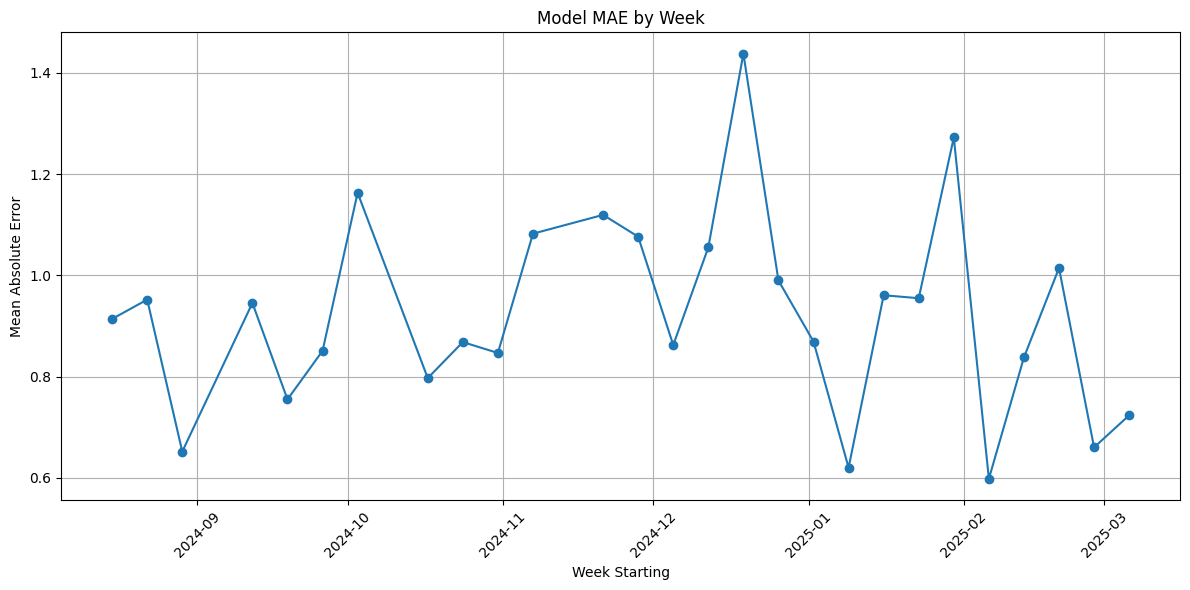


Summary Statistics:
Average Weekly MAE: 0.9216
Best Week MAE: 0.5982
Worst Week MAE: 1.4383


In [90]:
def evaluate_weekly(final_df, start_date, end_date, feature_cols, target_col="goals", 
                    promoted_teams=None, interval_days=7, verbose=True):
    """
    Evaluates a model on a week-by-week basis, simulating real-world prediction scenarios.
    
    Parameters:
    -----------
    final_df : pandas.DataFrame
        The processed DataFrame containing match data and features
    start_date : str or datetime
        The start date for evaluation (first training cutoff)
    end_date : str or datetime
        The end date for evaluation
    feature_cols : list
        List of feature column names to use for model training
    target_col : str, default="goals"
        The target column to predict
    promoted_teams : list, default=None
        List of promoted teams for special handling
    interval_days : int, default=7
        Number of days to increment between evaluation periods (typically 7 for weekly)
    verbose : bool, default=True
        Whether to print progress updates
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing performance metrics for each evaluation period
    """
    import pandas as pd
    import numpy as np
    from datetime import datetime, timedelta
    import xgboost as xgb
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    
    # Convert dates to datetime objects if they're strings
    current_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Prepare results storage
    weekly_results = []
    all_predictions = []
    
    # Convert categorical columns to category type if needed
    cat_cols = ["division"] #, "team", "opponent_team"
    X = final_df[feature_cols].copy()
    for col in cat_cols:
        if col in X.columns:
            X[col] = X[col].astype('category')
    
    # Set up XGBoost model parameters
    model_params = {
        'n_estimators': 100,
        'learning_rate': 0.05,
        'max_depth': 3,
        'subsample': 0.7,
        'colsample_bytree': 0.8,
        'min_child_weight': 3,
        'gamma': 0,
        'alpha': 1,
        'random_state': 26,
        'enable_categorical': True
    }

    # Loop through each week
    week_count = 0
    while current_date < end_date:
        week_count += 1
        next_date = current_date + timedelta(days=interval_days)
        
        if verbose:
            print(f"\nEvaluating week {week_count}: {current_date.date()} to {next_date.date()}")
        
        # Define training and test sets
        train_mask = final_df['match_date'] < current_date
        test_mask = (final_df['match_date'] >= current_date) & (final_df['match_date'] < next_date)
        
        # Skip if no test data for this week
        if test_mask.sum() == 0:
            if verbose:
                print(f"No matches found between {current_date.date()} and {next_date.date()}, skipping.")
            current_date = next_date
            continue
            
        # Create training and test sets
        X_train = X[train_mask]
        y_train = final_df.loc[train_mask, target_col]
        X_test = X[test_mask]
        y_test = final_df.loc[test_mask, target_col]
        
        # Skip if training data is insufficient
        if len(X_train) < 50:  # Arbitrary minimum threshold
            if verbose:
                print(f"Insufficient training data ({len(X_train)} samples), skipping.")
            current_date = next_date
            continue
        
        if verbose:
            print(f"Training on {len(X_train)} matches, testing on {len(X_test)} matches")
            
        # Train model
        model = xgb.XGBRegressor(**model_params)
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # Store weekly results
        weekly_results.append({
            'week_starting': current_date,
            'week_ending': next_date - timedelta(days=1),  # Subtract 1 day for inclusive range
            'matches_tested': len(X_test),
            'matches_trained': len(X_train),
            'mae': mae,
            'rmse': rmse
        })
        
        # Store detailed predictions for further analysis
        match_predictions = pd.DataFrame({
            'match_date': final_df.loc[test_mask, 'match_date'],
            'team': final_df.loc[test_mask, 'team'],
            'opponent_team': final_df.loc[test_mask, 'opponent_team'],
            'home': final_df.loc[test_mask, 'home?'],
            'division': final_df.loc[test_mask, 'division'],
            'actual_goals': y_test.values,
            'predicted_goals': y_pred,
            'error': y_test.values - y_pred,
            'abs_error': np.abs(y_test.values - y_pred),
            'eval_week': week_count
        })
        all_predictions.append(match_predictions)
        
        if verbose:
            print(f"Week {week_count} MAE: {mae:.4f}, RMSE: {rmse:.4f}")
        
        # Move to next week
        current_date = next_date
    
    # Create final results DataFrame
    results_df = pd.DataFrame(weekly_results)
    all_predictions_df = pd.concat(all_predictions, ignore_index=True) if all_predictions else pd.DataFrame()
    
    if verbose:
        print("\nWeekly Evaluation Complete")
        print(f"Overall MAE: {all_predictions_df['abs_error'].mean():.4f}")
        print(f"Total matches evaluated: {len(all_predictions_df)}")
        
    return results_df, all_predictions_df

# Define feature columns
feature_cols = ["division", "home?", "avg_market_value", "opponent_avg_market_value", #"xg_interaction",
                "rolling_goals_for", "rolling_xg_for", "rolling_shots_for", "rolling_shots_on_target_for", "rolling_corners_for", "rolling_deep_for", "rolling_ppda_for",
                "opponent_rolling_goals_against", "opponent_rolling_xg_against", "opponent_rolling_shots_against", "opponent_rolling_shots_on_target_against", "opponent_rolling_corners_against", "opponent_rolling_deep_against", "opponent_rolling_ppda_against"]


# Set evaluation period
start_date = "2024-08-01"  # Start after a few games have been played
end_date = "2025-03-17"    # End with the most recent data

# Run weekly evaluation
weekly_results, all_predictions = evaluate_weekly(
    final_df, 
    start_date=start_date,
    end_date=end_date,
    feature_cols=feature_cols,
    promoted_teams=["Ipswich", "Leicester", "Southampton"]
)

# Visualize results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(weekly_results['week_starting'], weekly_results['mae'], marker='o')
plt.title('Model MAE by Week')
plt.xlabel('Week Starting')
plt.ylabel('Mean Absolute Error')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print(f"Average Weekly MAE: {weekly_results['mae'].mean():.4f}")
print(f"Best Week MAE: {weekly_results['mae'].min():.4f}")
print(f"Worst Week MAE: {weekly_results['mae'].max():.4f}")

all_predictions.to_csv("preds.csv")